In [5]:
%load_ext autoreload
%autoreload 2


import os
import sys
import glob
import torch
import json
import pandas as pd
import time
import qgrid
import torch


from chofer_torchex.utils.logging import FolderStorageReader
from chofer_torchex.utils.run_experiments import keychain_value_iter
from collections import defaultdict, OrderedDict
from pathlib import Path


from core.logger_reader import LoggerReader

from matplotlib import cm

import matplotlib.pyplot as plt
import matplotlib
# import mpld3
# mpld3.enable_notebook()
%matplotlib inline

In [6]:
# root = Path('/scratch1/chofer/tdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYAAAAD8CAYAAAB+UHOxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvOIA7rQAAIABJREFUeJzt3Xl8m+WV6PHf8b7JiXfZsUM2R4rDkhDDQFLoQtgLFMoSpgvdJvPplLbTdrpN7+3M7dz7mZlL2ylzm2knhU6h0CaUQklp2ELpUEohdlgjJ05MNjvymsWSd1t67h+SHcfYiW3JeiW95/v5+GNLftFzIhKd933O8z5HjDEopZSynxSrA1BKKWUNTQBKKWVTmgCUUsqmNAEopZRNaQJQSimb0gSglFI2FZUEICI/FZEOEdk9xe9FRP5dRJpE5C0RuTAa4yqllJq9aF0B/Ay45gy/vxaoDn9tBH4UpXGVUkrNUlQSgDHmReD4GQ65CXjQhLwCzBeR8miMrZRSanbSYjTOAqB53OOW8HOtEw8UkY2ErhLIzc1d43a7YxKgUkolg127dnUZY0qmc2ysEoBM8tyke1AYYzYDmwFqa2tNfX39XMallFJJRUQOT/fYWK0CagGqxj2uBLwxGlsppdQkYpUAtgEfD68GugToNsa8a/pHKaVU7ERlCkhEfgm8DygWkRbgH4B0AGPMj4HtwHVAE9AHfDIa4yqllJq9qCQAY8ydZ/m9AT4XjbGUUkpFh94JrJRSNqUJQCmlbEoTgFJK2VSs7gNQSsUZYwyP1DeTmpLCyop8lpXmkZ6q54R2oglAKZv6w75Ovv7rt8ceZ6Sl4CpzUFOez8oF+aysyMftzCc3Uz8mkpX+n1XKhoJBwz1PN1JVmM19H7+IvW0+PF4fDV4fzza0sbU+tHOLCCwuyqWmIp+VFfNYWZFPTUU+xXmZFv8JVDRoAlDKhp58u5WGVh8/uGMVLqcDl9PBTasWAKGpodbuATxeHx5vNw1eH68fOcmTb526d7MsP/NUQigPJYeqwmxEJtv1RcUrTQBK2cxwIMj3n23E7XRw4wUV7/q9iFAxP5uK+dlcWVM29vzJviEavD4aWn1jyeEPjR0Ew7t6ObLSqCnPP+1qQesK8U0TgFI280h9M4eO9XH/XbWkpEz/jH1+TgZrlxWzdlnx2HMDwwH2tvlpCCcEj9fHL3ceYWA4CGhdId7p/wWlbGRgOMC/P7+fNecU8AF3acSvl5Weyqqq+ayqmj/2XCBoONjVE75KCCWGZ85SV1hZkU+R1hViThOAUjbywMuHaPcN8v/uvHDO5utTU4RlpQ6WlU5dV/BMqCukpghPfG4d5y6YNycxqclpAlDKJrr7h/mPP7zD+1wlXLy4MKZjn6muUHfoBH/1YD27Dp/QBBBjWp1RyiZ+8uIBuvuH+burXFaHMmZ+TgbrV5QyPyedvW0+q8OxHU0AStlAh3+A+186yA0XVMTdWbaI4CpzsLfNb3UotqMJQCkb2PT7JoYCQb585XKrQ5nUivJ89rX5CQYn7RSr5ogmAKWSXPPxPn6x8wh3XFTF4uJcq8OZlMvpoHcoQMuJfqtDsRVNAEoluX97bh8pInzhA9VWhzIll9MBoHWAGNMEoFQS29vm4/E3jvKJdYtwzsuyOpwpucpCCaBR6wAxpQlAqST23Wf2kZeZxmffu9TqUM4oNzONhYU57G3XBBBLmgCUSlK7Dp9gx552/vryJczPybA6nLNyOR3sbdUpoFiKSgIQkWtEpFFEmkTkG5P8/hMi0ikib4S/PhONcZVSkzPG8H+f3ktxXiafXLfY6nCmxe10cOhYHwPDAatDsY2IE4CIpAKbgGuBGuBOEamZ5NCtxphV4a/7Ih1XKTW1F/d38erB43z+A8sSZuM1tzOfQNDQ1NFjdSi2EY0rgIuBJmPMAWPMELAFuCkKr6uUmoVgMHT2X1mQzZ0XL7Q6nGkbXQlk90KwMbG7FyIaCWAB0DzucUv4uYk+LCJvicijIlIVhXGVUpPYvrsVj9fHl69cTkZa4pT5FhXlkJGWYvuloP/6dCPX/ODFmCSCaPztmGxLwYmR/xZYZIw5H9gBPDDli4lsFJF6Eanv7OyMQnhK2cdwIMj3nt2Hq+zUTpyJIi01heVlebbfEuLtoydJS5WYdFeLRgJoAcaf0VcC3vEHGGOOGWMGww9/AqyZ6sWMMZuNMbXGmNqSkpIohKeUfTy6q4WDXb383dUuUmfQ7CVeuMrybT0FZIyhwetjZXls9muKRgKoA6pFZLGIZAAbgG3jDxCR8nEPbwT2RGFcpdQ4A8MBfrBjHxcunM/6FZE3e7GC2+mgwz/I8d4hq0OxRGv3ACf6hlm5ID8m40WcAIwxI8DdwDOEPtgfMcZ4ROQ7InJj+LAviIhHRN4EvgB8ItJxlVKne/DPoWYvX7vGnbDN2e2+JYTHG/pz15THJgFEZX2YMWY7sH3Cc98e9/M3gW9GYyyl1Lv5BkLNXi5fXsIlS4qsDmfW3OWnVgKtXVp8lqOTT4PXh0hod9RYSJwlAkqpKf3kxQOc7Bvma1fHT7OX2SjJy6QwN8O2dQCPt5vFRbkxu3dDE4BSCa7TP8j9Lx3k+vPL467Zy0yNNofZY9ME0NDqY0VFbM7+QROAUglv0wtNDI4E+UqcNnuZKZfTwf52+zWH6e4bpuVEPys1ASilpqP5eB8Pv3qY22srWVKSZ3U4UbGi3EHfUIDmE31WhxJTntZuIHYFYNAEoFRC+7cd4WYvV8Rvs5eZcjlDH4B2uyGsIbwCaGVF7KbxNAEolaAa2/w8/vpR7lq7iPJ52VaHEzXLy/IQgb2t9ksApY5MShyZMRtTE4BSCeq7zzaSlxH/zV5mKicjjXMKc2hst9e9AB6vj5oYzv+DJgClEtJrR07wXEM7Gy9fQkFu/Dd7mSmX02GrKaCB4QBNnT0xLQCDJgClEs6pZi8ZfOo9idHsZaZcznwOdfXapjnMvnY/gaCJ6fw/aAJQKuH8cX8Xrxw4zt3vT5xmLzPldjoIGtjfbo/mMA0x3gJilCYAZSuHuno50Jm4HyrBoOGeZxpZMD+bO/8icZq9zJTbZnsCebw+8jLTWFiYE9Nxk/P0QalxgkHDf+/r5GcvH+K/93WSkZbCv374PG5eXWl1aDP21O423j7azfduu4DMtFSrw5kz5xTlkpWeYpstITzeblaUO0iJ8RbemgBU0vINDPOr+hZ+/udDHDrWR6kjk79dX80rB47xpa1vsrfVz9eucSfMvvkjgSDfe7aR5WV5fGh1YjV7manUFKG61B6F4EDQsLfNz+21sW+UqAlAJZ2mDj8PvHyYX7/WQt9QgDXnFPDlq1xcs9JJRloKw4Eg3/ltA//54gH2tfu5987V5GelWx32WT26q4UDXb1s/tiahElakXA5HfyhMfm7Ah461kvfUCDmS0BBE4BKEoGg4fd7O3jg5UO81NRFRloKN15QwSfWLnrXBmnpqSn804fOxeV08I/bPNy86U/cd9dFLC7OtSj6sxsYDnDv8/tZvXA+V9aUWR1OTLidDh7d1cKxnkGK8mJ3c1SsxboHwHiaAObQyb4h8rPSYz6vZyfdfcNsrT/Cz185TPPxfsrnZfHVq11suKjqrB8aH73kHJaV5vHZh3Zx0w9fYtNHLuSy6vhsQ/rzPx+mtXuA79++KmGbvcyUO7wlRGObn7XLkjcBNHh9pKcKy8scMR9bE8Acaero4dp7Xwyt1rh4IR9eU0lxEp/FxFpjm5+fvXyI37x+lP7hABcvLuSb167gqpoy0lKnv7jtkiVFbLv7PfzVg/Xc9dOdfOv6Gj61blFcfciGmr00cVl1MZcuTdxmLzM12h1sT5uftcuStzmMx9tNdamDjLTYL8rUBDBHttYdwRgocWTyz0/t5bvPNnLVSicfuXghlywp0quCWRgJBNmxp52fvXyIVw4cJzMthQ+tWsBdaxdFNH9aVZjDrz+7li8/8gb/9GQDe1t9/O+bz42bVTb3vXiAE33DfO1qt9WhxFSJI5PivAwak3gp6GgT+Pe7renhrAlgDgyNBPn1a0e5sqaMH310DU0dfn7xajO/fq2F373VyqKiHL0qmIETvUNsqWvmoVcOc/RkPwvmZ/ONa93cUVsVtW0QcjPT+NFH1nDv8/u59/n9vNPZw48/toZSR1ZUXn+2unoGue+lg1x/XjnnVSZ2s5fZcDkdSb0UtMM/yLHeoZhvATFKE8Ac2LGnneO9Q9xxUWhZ17JSB9++oYavXePi6d1t/OLVI3pVMA0ebzcPvHyIJ97wMjgSZO3SIr59Qw3rV5TNySqYlBThS1cux+V08JVH3uSmH/6Jn3y81tIuW6PNXr58VXI0e5kpV1k+v9h5mEDQJOXKJ4839j0AxtMEMAd+ufMIFfOy3lVQzEpP5UOrF/Ch1Qv0qmAKw4Egz3jaeODlQ9QdOkF2eiofXlPJXZcuGpsTnmvXnVfOOUU5bHxwF7f++GXuufUCbrigIiZjj9dyoo+HXznCbWsqWZokzV5myu10MDAc5MjxvrhepTVbY1tAJPIVgIhcA9wLpAL3GWP+ZcLvM4EHgTXAMeAOY8yhaIwdb5qP9/FSUxdf+ED1Gc9Y9KrgdF09g2zZeYSHXjlCm2+AhYU5/I/rV3Dbmirm5cR+jf7Kink8cfc6PvvQLj7/y9fZ2+bjK1e6Yvr/4wc79oPAF9cnT7OXmXKXh5J+Y5svKROAx+vjnKIcHBbdhxJxAhCRVGATcCXQAtSJyDZjTMO4wz4NnDDGLBORDcC/AndEOnY8+tWuFgBuq53eNgN2vyp4q+UkP3v5EE++2cpQIMhl1cX8n5vP5X2uUssv+YvzMnn4M5fw7Sd2s+mFd2hs6+EHG1aRF4MN2Pa3+3nstRY+/Z7FSdXsZaaqSx2h5jBtfq45t9zqcKKuodVn2fQPROcK4GKgyRhzAEBEtgA3AeMTwE3AP4Z/fhT4oYiIMSapuj4HgoZf1TdzWXUJlQUz39TJLlcFQyNBntrdys9ePsTrR06Sm5HKhour+Pili1hWGl9THRlpKfzzLeexojyf7zzZwC3/8Sfu+/hFLCya2027vvtsIzkZaXz2fcvmdJx4l52RyqKi3KTsDuYbGObwsT5uW2PdnlTRSAALgOZxj1uAv5jqGGPMiIh0A0VA18QXE5GNwEaAhQsTa7fDF/d30to9wP/8YE1Er5OsVwUd/gF+8eoRHn71CJ3+QRYX5/IPN9Rw65pKyy6Bp0NEuGttKDn9zcOvceOml/iPj1zI2qVzszb99SMneMbTzpfWL6cwCZu9zJQ7SZvD7LGgB/BE0UgAk52OTjyzn84xoSeN2QxsBqitrU2oK4StO5spzM1g/Yro3ao//qrgqd2t/PLV5rGrgqtXOvnLixdy6dKiuLlxqWdwhJYTfTQf76flRB8tJ/ppPh76vr/Dz3DA8H5XCXetXcTl1SUJdTWzblkx2+5ex2ceqOdj9+/kH26o4WOXnBPV9z7U7KWRotwMPn1ZcjZ7mSmX08HTnjb6hwJkZ8THvRnR0NBqbQEYopMAWoDx29hVAt4pjmkRkTRgHnA8CmPHjU7/IDv2tPPJdYvm5I6+rPRUbl5dyc2rK9nf7ueXO0NXBU/G+Kqgb2iElhP97/6QD38/2Td82vHZ6alUFWZTWZDD5ctLuOOiqoQu5p1TlMtjf7OWL219g28/4WFPq5//dePKqP0/f6mpiz8fOMa3P1gTk1pDInA7HRgD+zv8nF853+pwosbj9VGcl0FpDJvATxSNv2F1QLWILAaOAhuAv5xwzDbgLuDPwK3A75Nt/v+x11oYCZqxtf9zqbps7q4KBoYDoQ/3E/1jH/Qt4z7oj/UOnXZ8ZloKlQXZVBXmsKpqPpUFOVQV5FBZkE1lQTaFuRlxc3USLY6sdDZ/rJbvPdfIphfe4Z2OHn700Qsj3rDMmFPNXj5ySWJNf84lV3hPoL2tyZcAVpTnW/rvI+IEEJ7Tvxt4htAy0J8aYzwi8h2g3hizDbgf+LmINBE6898Q6bjxxBjD1rpmas8pYFlp7DZ0ms1VwcBwAO/J/tPO2sdP03T1DJ42RkZq6AN+QUE2V1XMGzubryzIpqogh+K85PuAn46UFOGrV7tZXubga4++xY3hm8YiuZx/encbb7V0c8+t58fNNhTxYGFhDtnpqUlVBxgaCdLU4ee9y5dYGkdUrjGNMduB7ROe+/a4nweA26IxVjyqO3SCA129fPZ9Sy2L4UxXBZcuLaY3PDff7jv9Az49VaiYH/owX7+idOxsPnQGn0NJXmZCzdPH2k2rFrC4OJeND+7iwz96me/ffgHXnjfz5YojgSD3PNtIdWket1yYeJ3K5lJqirC8LI/G9uTZE2hfe6geZtUWEKN0kjEKttQdIS8zjevPt36d8mRXBX/c30lxXiaXV5ec9uFeVZhNqSPL8vX2ie78yvlsu3sdf/3QLj778Gt88YpqvnhF9YwS52OvHeVAZy8//qg9mr3MlMvp4Pk9HVaHETXxUAAGTQAR6+4fZvvbrdxyYSU5GfH1do5eFai5V5qfxZaNl/Ctx3dz7/P7aWzz873bLyB3GoXcgeEA/7ZjHxdUzefqlfZo9jJTLmc+j9S30OkfpMTComm0NHh95GSksrjI2gURsd+AOslse9PLwHCQDTEo/qr4lpmWyj23ns//uH4Fzza08eEfvUzz8b6z/ncPvRJq9vL1q122rKdMxwrn6JYQyVEHCDWBz7d8elUTQIS21h1hRXk+51m4Y6SKHyLCZy5bwn998mKOnuznpk1/YufBqVc8+weG2fRCE+9ZVpzUTU8iNboR4N4k6A0QDBr2tPot3QJilCaACOw+2s3uoz42XFSlZ27qNO9dXsITn1vH/Jx0/vInr/CLV49Metx9fzzIib5hvnq1K8YRJpaivEyK8zKTYiXQkeN99AyOWF4ABk0AEdla10xGuCuVUhMtKcnjN59bx3uqi/n7x9/m20/sZjgQHPv9sZ5B7vvjAa4918kFVcmzvn2urChPjuYwHou3gB5PE8As9Q8F+M0bR7nuXKcl2xWrxJCflc79d13EX1++hAf/fJiP37+TE+Gb6Ta98A79wwG+cpWe/U+Hq8zBvnY/gWBi30Pa0NodXtoa+ybwE2kCmKWndrfiHxjhjov0jk11ZqkpwjevW8H3b7+AXUdOcOOml3hhbwcPvXKYW9dUxt0OqPHK5XQwOBLk8LFeq0OJiMfro7o0j6x062/20wQwS1vqmllUlMMlSwqtDkUliFsurGTrxksYHA7yyZ/VhZu92LPV42y4R7eESPBpoAavtT0AxtMEMAsHOnvYefA4t2vxV83Q6oUF/Pbz7+Gy6mK+tH45C+bbt9nLTFWX5ZEiiZ0AOv2DdPgH42L+H/RGsFnZWt9Maopwq96yr2ahLD+Ln396YssMdTZZ6aksKs6lMYGXgo42gbeyB8B4egUwQ8OBIL/e1cIH3KWU5mdZHY5StpLozWHGtoDQKaDE9PyeDrp6hvTOX6Us4CrL58jxPvqGRqwOZVY8Xh+VBdlxs3JQE8AMba07Qll+Ju9dXmJ1KErZjrs81BxmX3uP1aHMSjwVgEETwIx4T/bz3/s6uW1NFWmp+tYpFWvusT2BEq8O0DM4wqFjvXEz/w+aAGbk0V0tBA3cXqvTP0pZoaogh5yMVPa0Jl4dYG+rD2OIiy0gRmkCmKZgMNT1a92yIhYW5VgdjlK2lBK+gzYRt4SIlx4A42kCmKY/vdPF0ZP9euevUhZzOx00tvtJtLbinqM+CnLSKZ8XP6sHNQFM05a6ZubnpHNVjTbsUMpKLqeD471DdE7oXx3vPK3drKyYF1c3j2oCmIbjvUM862nj5tUL4mL/DqXsbKw3QALVAYYDQfa19cTV9A9EmABEpFBEnhOR/eHvBVMcFxCRN8Jf2yIZ0wqPvdbCcMBwh679V8pyo3sCJVIdoKmjh6FAMK4KwBD5FcA3gOeNMdXA8+HHk+k3xqwKf90Y4ZgxZUyo+Luqav7YXzyllHUKczModSRWc5ixHgBxdA8ARJ4AbgIeCP/8APChCF8v7rx25CT7O3r0zl+l4ojL6Uio9pANXh9Z6SksKYmvrb8jTQBlxphWgPD30imOyxKRehF5RUTOmCREZGP42PrOzs4Iw4vc1roj5GSk8sELKqwORSkVtqI8n/0dPYyM67AWzzzebtzOfFItbgI/0Vl3AxWRHYBzkl99awbjLDTGeEVkCfB7EXnbGPPOZAcaYzYDmwFqa2stXeflHxjmt2+2cuMFFeRl6sapSsULV5mDoZEgh471xX1DHWMMDa0+bojDk8izfqoZY9ZP9TsRaReRcmNMq4iUAx1TvIY3/P2AiPwBWA1MmgDiyZNvtdI/HOCOi3X6R6l44hrbEsIf9wmg5UQ//oH4aAI/UaRTQNuAu8I/3wU8MfEAESkQkczwz8XAOqAhwnFjYktdM8vL8litDbuViivLSvNITZGEqAPEWw+A8SJNAP8CXCki+4Erw48RkVoRuS98zAqgXkTeBF4A/sUYE/cJYE+rjzebT3LHRQvj6sYNpVSoOczi4tyEWAnU4PWRIqFpq3gT0cS2MeYYcMUkz9cDnwn//DJwXiTjWGFrXTMZqSncvHqB1aEopSbhcjp4u6Xb6jDOyuP1sbQkj+yM+LuJVO8EnsTAcIDHXz/KVSvLKMzNsDocpdQk3GUOjhzvo3cwvpvDNLT64u4O4FGaACbxjKeN7v5hNujGb0rFrbFCcHv8TgMd7x2itXsgLgvAoAlgUlvrmqksyGbt0iKrQ1FKTWFFefxvCRHPBWDQBPAuh4/18vI7x7ijtoqUOLtpQyl1yoL52eRmpMZ1AmiI0y0gRmkCmOCR+mZSBG6trbQ6FKXUGaSkCMudDva0xu9SUI/XR8W8LAritJaoCWCckUCQX9W38D5XKeXzsq0ORyl1Fm5nflw3h/F4u6mJ0+kf0ARwmj80dtLhH9Rtn5VKEG6ng5N9w3T44685TN/QCAe6euN2BRBoAjjNlrpmivMy+YB7qj3tlFLxZKw5TBzWAfa2+eOuCfxEmgDC2n0DvNDYwa1rKklP1bdFqUTgHusOFn91gHgvAIMmgDGP7mohENSuX0olkvk5GTjzs+JyJZDH62NedjqVBfFbT9QEAASDhkfqm/mLxYUsLs61Ohyl1AyEmsPEXwJo8HZTU54f13uJaQIAXjl4jMPH+tig2z4rlXDcTgdNcdYcZiQQZG+bP64LwKAJAAjd+evISuPac8utDkUpNUMup4OhQJCDXb1WhzLmQFcvgyPx1wR+ItsngJN9Qzy1u42bVy8gKz3+dutTSp2Z2xn6kI2naaB43wJilO0TwG9eP8rQSFCLv0olqKWluaSmSFwVghu8PjLSUlhSEt81RVsnAGMMW+qaOW/BvLjP1EqpyWWmpbKkODeuuoN5vD7cTkfcLymP7+jm2Fst3ext8+vZv1IJzl2eHzdTQKNN4ON5/f8oWyeALXXNZKWncOOqCqtDUUpFwO100HKin544aA7j7R7gZN9w3BeAwcYJoHdwhG1vHOX68yrIz0q3OhylVARG++3GQx3AczRUAI7nTeBG2TYB/O7tVnqHArr2X6kkcGpPIOvrAA2tPkRObVMRzyJKACJym4h4RCQoIrVnOO4aEWkUkSYR+UYkY0bL1rpmlpTkUntOgdWhKKUiVFmQTV5mWnxcAXh9LC7OJTczzepQzirSK4DdwC3Ai1MdICKpwCbgWqAGuFNEaiIcNyL72/3sOnyCDRdVxfVt2kqp6RGRuNkSosHrS5hVhRElAGPMHmNM41kOuxhoMsYcMMYMAVuAmyIZN1Jb65pJSxFuuVC7fimVLFxOB41t1jaHOdk3xNGT/QmxAghiUwNYADSPe9wSfm5SIrJRROpFpL6zszPqwQyOBHjs9aNcWVNGcV5m1F9fKWWNFU4H3f3DtPkGLIthdAvoRFgBBNNIACKyQ0R2T/I13bP4yeZYpkzRxpjNxphaY0xtSUnJNIeYvh0NHRzvHdK1/0olGVccbAnREO5LEO+bwI06a5XCGLM+wjFagPGftpWAN8LXnLUtdUeomJfFZdXRTy5KKeuMXwr6fpc1Xf08Xh9l+ZkJM7sQiymgOqBaRBaLSAawAdgWg3Hfpfl4Hy81dXFbbRWpKVr8VSqZzMtJp3xelqXdwTze7oQpAEPky0BvFpEW4FLgdyLyTPj5ChHZDmCMGQHuBp4B9gCPGGM8kYU9O7/a1QLAbbVa/FUqGbktXAk0MBzgnc7ehCkAwzSmgM7EGPM48Pgkz3uB68Y93g5sj2SsSAWChl/VN3NZdQmVBTlWhqKUmiMuZz4vNXUxHAjGfCO2xjY/gaBJmAIw2OhO4Bf3d9LaPcAGLf4qlbTcTgfDAWNJcxjP2Aogm0wBJZKtO5spzM1g/Yoyq0NRSs2R0S0h9lhQB2ho7caRmRbXTeAnskUC6PQPsmNPOx++cAEZabb4IytlS0tL8kizqDmMx+tjRUU+KQm0wMQWn4aPvdbCSNDo2n+lklxGWgpLS/JingACQcPeVn9Czf+DDRKAMYatdc3UnlPAstL4351PKRUZK/YEOtjVS/9wIKFWAIENEkDdoRMc6OrVs3+lbMJd7uDoyX58A8MxGzNRmsBPlPQJYEvdEfIy07j+/HKrQ1FKxcDoPvz7YngV0NDqIz1VWFaaF7MxoyGpE0B3/zDb327lxlUV5GTE/97cSqnIWbEnUIPXx/IyR8ItMkmsaGdo25teBoaDuvZfKRupmJeFIystZt3BjDF4vL6EKwBDkieArXVHWFGez3kLEmteTik1eyKCO9wbIBbafYMc7x1KuAIwJHEC2H20m91Hfdr1SykbGl0JFIvmMGMF4AQ80UzaBLC1rpmMtBQ+tGrK3jNKqSTlcubjHxihtXvum8OMNoFZoVcA8aF/KMBv3jjKdec6mZeTbnU4SqkYG10JFIs6gMfrY1FRDnkJ0AR+oqRMAE/tbsU/MMIdFy20OhSllAVcYwlg7usAntbE6gEwXlImgC11zSwqyuGSJYVWh6KUskB+VjoL5mfPeSG4u3+Y5uP9CdMCcqKkSwA9gyN0+Aa4XYu/StmaKwaqcICwAAAMmElEQVQrgfYkWA/giRJv0uos8jLT+P1X3sdwMGh1KEopC7mdDl7c18nQSHDObtBqGOsBkJgJIOmuAABSUoTMtFSrw1BKWcjldDASNBzo6pmzMTxeH8V5mZQ6suZsjLmUlAlAKaXc4S0h5nIaKNQEPjHP/kETgFIqSS0pySU9VdjTOjcJYHAkQFNHj30TgIjcJiIeEQmKSO0ZjjskIm+LyBsiUh/JmEopNR3pqaPNYebmXoD97T2MBE3CFoAh8iLwbuAW4D+ncez7jTFdEY6nlFLT5nY62Hnw+Jy8dqL2ABgvoisAY8weY0xjtIJRSqlocjnz8XYP0N0f/eYwDV4fuRmpnFOYE/XXjpVY1QAM8KyI7BKRjWc6UEQ2iki9iNR3dnbGKDylVDJyl4fuCJ6LQrDH62NFeWI1gZ/orAlARHaIyO5Jvm6awTjrjDEXAtcCnxORy6c60Biz2RhTa4ypLSkpmcEQSil1utE9gaJdBwgGDXtaE7MHwHhnrQEYY9ZHOogxxhv+3iEijwMXAy9G+rpKKXUmzvws8rPSor4n0OHjffQOBRK6AAwxmAISkVwRcYz+DFxFqHislFJzKtQcJj/qU0DJUACGyJeB3iwiLcClwO9E5Jnw8xUisj18WBnwkoi8CewEfmeMeTqScZVSarrc5aE9gaLZHKbB6yMtRaguS6wm8BNFtAzUGPM48Pgkz3uB68I/HwAuiGQcpZSaLZfTgX9whKMn+6ksiM6KHY/Xx7LSvITfckbvBFZKJbVTheDoTQOFmsAn9vQPaAJQSiW55WXRbQ7T4R+gq2cw4QvAoAlAKZXkHFnpVBZkRy0BeBJ8C+jxNAEopZKe2+mI2r0Aoz0A9ApAKaUSgMvp4EBnL4MjgYhfq8Hro6owm/ys9ChEZi1NAEqppOd25jMSNLzT0Rvxa3m83awsT/wCMGgCUErZwNhKoPbIpoF6Bkc4dKwvKeb/QROAUsoGFhXnkpGaEnEhONGbwE+kCUAplfTSU1NYWpoX8b0AnqPJsQXEKE0ASilbWOF0sDfC9pANrT4KczMoy8+MUlTW0gSglLIFl9NBm2+A7r7ZN4cJ3QGcj0ji9gAYTxOAUsoWXM7RO4JnVwgeGgmyv70naeb/QROAUsomVpSHPrhnWwhu6uhhKBCkplwTgFJKJZRSRybzc9JnnQCSpQfAeJoAlFK2ICK4yma/JURDq4/s9FQWF+dGOTLraAJQStmG2+lgX3sPweDMm8N4vD7c5Q5SE7gJ/ESaAJRStuEuz6cn3BxmJoJBwx5v4jeBn0gTgFLKNk6tBJpZHaDlRD/+wRFqkmQPoFGaAJRStjHaHGamdYBTBWC9AlBKqYSUl5lGVeHMm8M0tPpITZGxK4hkoQlAKWUrbmf+jBOAx+tjaUkuWemJ3QR+oogSgIjcIyJ7ReQtEXlcROZPcdw1ItIoIk0i8o1IxlRKqUi4nQ4Ods2sOYzH251U6/9HRXoF8BxwrjHmfGAf8M2JB4hIKrAJuBaoAe4UkZoIx1VKqVlxOR0Egoamjp5pHd/VM0i7bzDp5v8hwgRgjHnWGDMSfvgKUDnJYRcDTcaYA8aYIWALcFMk4yql1Gy5neEtIaa5M+hYD+Ak2gJiVDRrAJ8Cnprk+QVA87jHLeHnJiUiG0WkXkTqOzs7oxieUkrBoqIcMtJSaGyfZgJIsiYw46Wd7QAR2QE4J/nVt4wxT4SP+RYwAjw82UtM8tyUt+EZYzYDmwFqa2tnfrueUkqdQVpqCtWledMuBHu8PhbMz2Z+TsYcRxZ7Z00Axpj1Z/q9iNwFfBC4whgz2Qd2C1A17nEl4J1JkEopFU0up4M/NXVN61iPtzspz/4h8lVA1wBfB240xvRNcVgdUC0ii0UkA9gAbItkXKWUisQKZz7tvkFO9A6d8bi+oREOdvUmZQEYIq8B/BBwAM+JyBsi8mMAEakQke0A4SLx3cAzwB7gEWOMJ8JxlVJq1qa7JcSeVj/GJGcBGKYxBXQmxphlUzzvBa4b93g7sD2SsZRSKlrczlNbQly6tGjK4xpGt4BYkHz3AIDeCayUsqESRyYFOelnXQnU0Opjfk46FfOyYhRZbGkCUErZjojgduaz5yz3Ani8PmrKk6cJ/ESaAJRStuRyOtjX7p+yOcxIIMjeNn/SFoBBE4BSyqbcTgd9QwFaTkzeHOadzl6GRoJJuwQUNAEopWzKHV7Zs2eK3gDJ2AR+Ik0ASilbWl6Whwg0TrEUtMHrIzMthSVJ1AR+Ik0ASilbyslIY2FhzpQJwOP14XY6SEtN3o/J5P2TKaXUWbjKHOydZArIGBPeAiJ5p39AE4BSysbc5fkc7OplYPj05jBHT/bjGxhJ6hVAoAlAKWVjbqeDoOFdzWE83uTdAno8TQBKKduaak+gBq+PFAltGpfMNAEopWxrUVEumWkpNE6oA3i8PhYX55KdkVxN4CfSBKCUsq3UFGF5mWOSK4DkbAI/kSYApZStuZynJ4ATvUN4uweSvgAMmgCUUjbndjro9A9yrGcQSO4ewBNpAlBK2Zo7XOgdvSHMDltAjNIEoJSytYkrgRq8PsrnZVGYm3xN4CfSBKCUsrUSRyZFuRnjrgB8SdsCciJNAEop23M5Hext9zMwHOCdzh5bFIBBE4BSSuF25rOvzU9Dq4+gsUcBGCJsCi8i9wA3AEPAO8AnjTEnJznuEOAHAsCIMaY2knGVUiqa3E4H/cMBntndBtijAAyRXwE8B5xrjDkf2Ad88wzHvt8Ys0o//JVS8Wa0EPz460dxZKVRWZBtcUSxEVECMMY8a4wZCT98BaiMPCSllIqt5WUORKDDP5jUTeAnimYN4FPAU1P8zgDPisguEdl4phcRkY0iUi8i9Z2dnVEMTymlJpedkcqiolDnL7tM/8A0agAisgNwTvKrbxljnggf8y1gBHh4ipdZZ4zxikgp8JyI7DXGvDjZgcaYzcBmgNraWjONP4NSSkXMVebgYFevbVYAwTQSgDFm/Zl+LyJ3AR8ErjDGTPqBbYzxhr93iMjjwMXApAlAKaWs4HI6eNrTZpsVQBD5KqBrgK8D7zXG9E1xTC6QYozxh3++CvhOJOMqpVS03bqmkpFgkOVlDqtDiZlIawA/BByEpnXeEJEfA4hIhYhsDx9TBrwkIm8CO4HfGWOejnBcpZSKqqrCHL56tZvUFHsUgCHCKwBjzLIpnvcC14V/PgBcEMk4Simlok/vBFZKKZvSBKCUUjalCUAppWxKE4BSStmUJgCllLIpTQBKKWVTmgCUUsqmZIrdG+KCiHQCh2f5nxcDXVEMJ5Hpe3E6fT9Op+/HKcnwXpxjjCmZzoFxnQAiISL12nsgRN+L0+n7cTp9P06x23uhU0BKKWVTmgCUUsqmkjkBbLY6gDii78Xp9P04nb4fp9jqvUjaGoBSSqkzS+YrAKWUUmegCUAppWwq6RKAiFwjIo0i0iQi37A6HiuJSJWIvCAie0TEIyJftDomq4lIqoi8LiJPWh2L1URkvog8KiJ7w39HLrU6JiuJyJfC/052i8gvRSTL6pjmWlIlABFJBTYB1wI1wJ0iUmNtVJYaAb5ijFkBXAJ8zubvB8AXgT1WBxEn7gWeNsa4CTVtsu37IiILgC8AtcaYc4FUYIO1Uc29pEoAhJrNNxljDhhjhoAtwE0Wx2QZY0yrMea18M9+Qv/AF1gblXVEpBK4HrjP6lisJiL5wOXA/QDGmCFjzElro7JcGpAtImlADuC1OJ45l2wJYAHQPO5xCzb+wBtPRBYBq4FXrY3EUj8AvgYErQ4kDiwBOoH/Ck+J3SciuVYHZRVjzFHgu8ARoBXoNsY8a21Ucy/ZEsBk3Zxtv85VRPKAXwN/a4zxWR2PFUTkg0CHMWaX1bHEiTTgQuBHxpjVQC9g25qZiBQQmi1YDFQAuSLyUWujmnvJlgBagKpxjyuxwWXcmYhIOqEP/4eNMY9ZHY+F1gE3isghQlODHxCRh6wNyVItQIsxZvSK8FFCCcGu1gMHjTGdxphh4DFgrcUxzblkSwB1QLWILBaRDEJFnG0Wx2QZERFCc7x7jDHftzoeKxljvmmMqTTGLCL09+L3xpikP8ObijGmDWgWEVf4qSuABgtDstoR4BIRyQn/u7kCGxTF06wOIJqMMSMicjfwDKEq/k+NMR6Lw7LSOuBjwNsi8kb4ub83xmy3MCYVPz4PPBw+WToAfNLieCxjjHlVRB4FXiO0eu51bLAthG4FoZRSNpVsU0BKKaWmSROAUkrZlCYApZSyKU0ASillU5oAlFLKpjQBKKWUTWkCUEopm/r/XZbCMTy63nwAAAAASUVORK5CYII=opreg/')
# root = Path('/tmp/debugging/')
# root = Path('/scratch1/chofer/cifar10/topreg_ours/')
# root = Path('/scratch1/chofer/topreg_mnist/')
# root = Path('/scratch1/chofer/topreg_rkwitt/')
root = Path('/scratch1/chofer/topreg/')

tag = None #'grid_1'


In [7]:
args_white_list = {
#  'output_root_dir',
#  'cv_run_num',
#  'ds_train_name',
#  'ds_test_name',
#  'ds_normalization',
#  'num_train_samples',
#  'num_augmentations',
#  'typ_augmentation',
 'num_intra_samples',
 'model_name',
 'cls_loss_fn',
#  'batch_size',
#  'num_epochs',
 'lr_init',
 'w_top_loss',
#  'weight_decay', 
 'weight_decay_feat_ext',
 'weight_decay_cls',
#  'w_top_loss_rampup_start',
#  'w_top_loss_rampup_end',
 'top_scale',
#  'num_branches', 
 'pers_type',
#  'compute_persistence',
 'tag'
}

stats_white_list = {
#     'lr', 
#     'batch_cls_loss', 
#     'batch_top_loss', 
    'acc_train', 
    'acc_test', 
}


def load_results():
    global RESULTS
    RESULTS = [LoggerReader(r) for r in glob.glob(str(root / '*'))]
    
    if tag is not None:
        RESULTS = [r for r in RESULTS if r.experiment_args['tag'] == tag]
        
    RESULTS = sorted(RESULTS, key=lambda x: x.date)

def args_df_from_results():
    load_results()
    R = []
    
    for i, r in enumerate(RESULTS):
        
        df = {k: str(v) if isinstance(v, (list, tuple)) else v for  k, v in r.experiment_args.items() if k in args_white_list}
        df['date'] = r.date
        df = pd.DataFrame(df, index=[i])
        
        try: 
            df['progress'] = str(r.progress)
        except FileNotFoundError:
            pass              
        
        
        R.append(df)   
        
    return pd.concat(R, sort=False)

def df_from_results():
    A = args_df_from_results()
    
    tmp = []
    for i, r in enumerate(RESULTS):
        v = r.values_by_run
        df = {}
        for k in ['acc_train', 'acc_test']:
            df[k] = np.mean([x[k][-1] for x in v.values()])
            
        tmp.append(pd.DataFrame(df, index=[i]))
    
    B = pd.concat(tmp, sort=False)
    return A.join(B)  


def fig_acc_train_test(selected_results, c_map, run_i):
    fig, axes = plt.subplots(1, 2)
    
    for id, (r, r_index) in enumerate(selected_results):
        
        for ax, s in zip(axes, ['acc_train', 'acc_test']):
            acc = np.array(r.values_by_run[run_i][s])   
            ax.set_title(s)
            ax.plot(acc, label='{} | {:.3f}'.format(str(r_index), acc[-1]),
                         color=c_map(id),
                         linewidth=1)
            
            ax.legend()
            
            
def fig_batch_stat(
    selected_results, 
    c_map,
    run_i, 
    stat_name,     
    log_scale=False):
    
    plt.figure()
    plt.title(stat_name)
    
    for id, (r, r_index) in enumerate(selected_results):
        
        try:
            stat = np.array(r.values_by_run[run_i][stat_name])        
            
        except KeyError:
            
            continue
            
        plt.plot(stat, label=str(r_index), color=c_map(id))
        
    plt.legend()
    
    if log_scale:
        plt.gca().set_yscale('log')        
        

def fig_lifetimes(
    selected_results,
    c_map, 
    run_i):
    
    plt.figure()
    plt.title('Lifetimes')
    
    for id, (r, r_index) in enumerate(selected_results):        
       
        p = [np.mean(x) for x in r.values_by_run[run_i]['batch_lt']]  
        plt.plot(p, label=str(r_index), color=c_map(id))
       
        
    plt.legend()
    
    
def fig_gradients(
    selected_results,
    c_map, 
    run_i):
    
    plt.figure()
    plt.title('Gradients')
    
    for id, (r, r_index) in enumerate(selected_results):
    
        try:
            p = np.array(r.values_by_run[run_i]['batch_grad_abs_mean'])            
            plt.plot(p, label=str(r_index), color=c_map(id))
            
            p = r.values_by_run[run_i]['batch_grad_abs_max']
            plt.plot(p, '--', label=str(r_index), color=c_map(id))

            p = r.values_by_run[run_i]['batch_grad_abs']
            plt.plot(p, '--', label=str(r_index), color=c_map(id))  
            
        except KeyError:
            pass            
        
    plt.legend()


def view_selected_results(selected_indices, args_oi: list):
    load_results()
    if selected_indices is None:
        selected_indices = list(range(len(RESULTS)))   
    
    selected_results = [(RESULTS[i], i) for i in selected_indices]
    colors = cm.get_cmap('nipy_spectral', len(selected_results)+1)
    
    run_i = 1
    
    fig_acc_train_test(selected_results, colors, run_i=run_i)    
    
    for s in ['batch_cls_loss', 'batch_top_loss', 'batch_cls_loss_1', 'batch_cls_loss_2']:
        fig_batch_stat(selected_results, colors, run_i, s, log_scale=True)
    
    fig_lifetimes(selected_results, colors, run_i)
    
    fig_gradients(selected_results, colors, run_i)
    
    
        
    def formatter(v):
        if isinstance(v, (float, int)):
            return '{:.4f}'.format(float(v))
        elif isinstance(v, str):
            return v
        else:
            return str(v)

    s = ' | '.join(('{:.4f'))
    for r, i in selected_results:
        
        args = r.experiment_args
            
        s = [formatter(args[a]) for a in args_oi]
        s = ['{:3d}'.format(i)] + s
        s = ' | '.join(s)
        
        print(s)

In [8]:
qgrid_widget = qgrid.show_grid(df_from_results(), show_toolbar=True)


ValueError: No objects to concatenate

In [ ]:
qgrid_widget

In [12]:
RESULTS[17].path

PosixPath('/scratch1/chofer/cifar10/topreg_ours/12-07-2019-20-40-56__CIFAR_topreg__79d8d135-994a-4da5-8fe5-662a8fd61ded')

In [8]:
qgrid_widget = qgrid.show_grid(args_df_from_results(), show_toolbar=True)
selected_indices = None
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [19]:
# df = df_from_results()
# selected_indices = df.query('tag==no_weight_decay_top').index

In [32]:
#selected_indices = qgrid_widget.get_changed_df().index
#print(selected_indices)

# 0 -> old reference; 84 -> new reference
selected_indices = [108]

No handles with labels found to put in legend.
No handles with labels found to put in legend.


108 | 0.5000 | CrossEntropyLoss | 0.0000


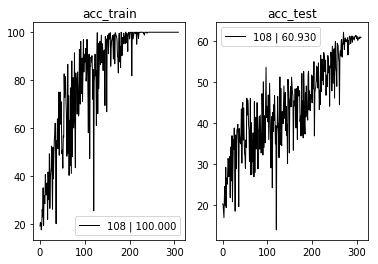

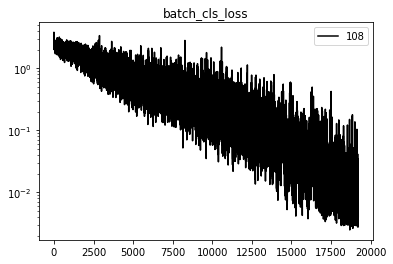

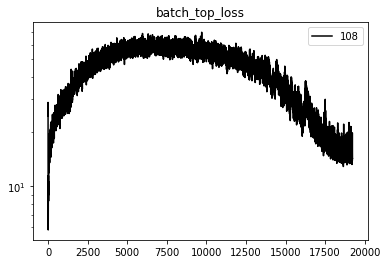

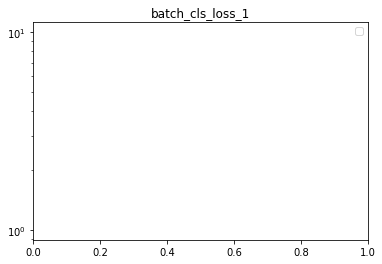

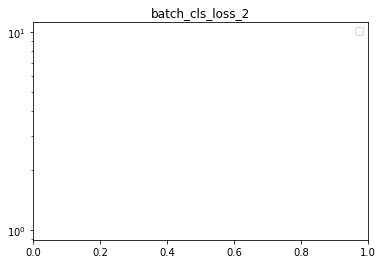

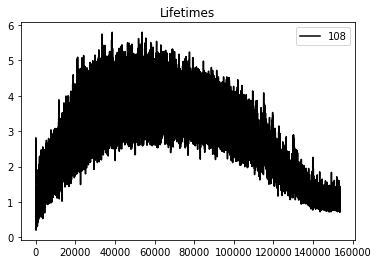

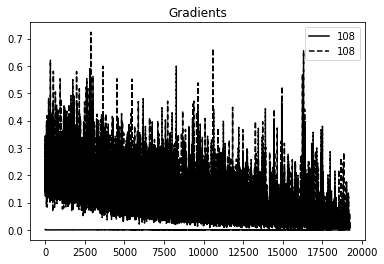

In [33]:
view_selected_results(selected_indices, args_oi=['lr_init', 'cls_loss_fn', 'top_scale'])

In [ ]:
#compare = [8,16,18,19,21,22,23,31,36,45]
compare = [1, ]
upto = 11
for c in compare:
    tmp = [RESULTS[c].values_by_run[i]['acc_test'][-1] for i in range(1,upto)]
    print(tmp)
    print('{}: {:.2f}'.format(c, np.mean(tmp)))

In [82]:
RESULTS[84].path

PosixPath('/tmp/debugging/11-19-2019-07-43-46__ce361f36-aae8-45cd-a0b3-51cd18e2ee2a')

In [38]:
r = RESULTS[108]
for i in range(1, 11):
    print(r.values_by_run[i]['acc_test'][-1])

60.92999999999999
61.85000000000001
62.32
63.18
62.419999999999995
64.89
62.93
63.54
62.5
64.37


In [79]:
#Lipschitz constant of CLS

for i in compare:
    m = RESULTS[i].load_model(1,'model')
    _,S,_ = np.linalg.svd(m.cls[0].weight.data.cpu().numpy(),full_matrices=False)
    print(i, S.max(), m.cls[0].bias.cpu().norm().item())
#RESULTS[2].experiment_args

38 5.4251657 0.7700545191764832
39 3.081674 0.3294202387332916


In [630]:
from core.experiments import *
from chofer_torchex.utils.data.ds_operations import ds_random_subset

DEVICE='cuda:0'
model = RESULTS[0].load_model(1, 'model').to(DEVICE)
model.eval()

pers_fn = VrPersistence('l2')

DS_TRAIN_ORIGINAL = ds_factory_stratified_shuffle_split('cifar10_train', 250)[0]
DS_TEST_ORIGINAL = ds_factory('cifar10_test')
DS_TEST_SAMPLE  = ds_random_subset(DS_TEST_ORIGINAL, absolute_size=len(DS_TRAIN_ORIGINAL))

assert len(DS_TRAIN_ORIGINAL) == len(DS_TEST_SAMPLE)

t = [transforms.ToTensor()]
ds_stats = ds_statistics(DS_TRAIN_ORIGINAL)
if True:
    t += [transforms.Normalize(
        ds_stats['channel_mean'],
        ds_stats['channel_std'])]
to_tensor = transforms.Compose(t)

augmenting_transform = AugmentingTransform('full_random_aug_auto', to_tensor)

def augment_ds(ds):    
    ds = RepeatedAugmentation(ds, augmenting_transform, 1)
    ds = IntraLabelMultiDraw(ds, 32)
    return ds

ds_train = augment_ds(DS_TRAIN_ORIGINAL)

ds_test  = augment_ds(DS_TEST_SAMPLE)

ds_train_test = torch.utils.data.dataset.ConcatDataset([DS_TRAIN_ORIGINAL, DS_TEST_SAMPLE])
ds_train_test = augment_ds(ds_train_test)
print(len(ds_train), len(ds_test), len(ds_train_test))

250 250 500


In [631]:
def compute_lifetimes(ds, model):    

    lifetimes = []
    drawn_batches = 0
    num_batches = 500
    batch_size = 8
    
    while True:   
        
        dl = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn,
        num_workers=0)
    
        for b_i, (batch_x, batch_y) in enumerate(dl):

            n = batch_x[0].size(0)
            assert n == 32*1
            assert all(((x.size(0) == n) for x in batch_x))

            x, y = torch.cat(batch_x, dim=0), torch.cat(batch_y, dim=0)
            x, y = x.to(DEVICE), y.to(DEVICE)

            with torch.no_grad():

                y_hat, z = model(x)
                l_cls = nn.functional.cross_entropy(y_hat, y)
                l_top = torch.tensor(0.0).to(DEVICE)

                for i in range(batch_size):
                    z_sample = z[i*n:(i+1)*n, :].contiguous()
                    lt = pers_fn(z_sample, 0, 0)[0][0][:, 1]
                    lifetimes.append(lt.cpu().tolist()) #convert(lt.mean()))
                    
            drawn_batches += 1
            
            if drawn_batches ==  num_batches:
                return lifetimes

In [713]:
model = RESULTS[16].load_model(1,'model').cpu()
model = model.to(DEVICE)
lt = {
    'lt_train': compute_lifetimes(ds_train, model),
    'lt_test': compute_lifetimes(ds_test, model),
    'ds_train_test': compute_lifetimes(ds_train_test, model)
}

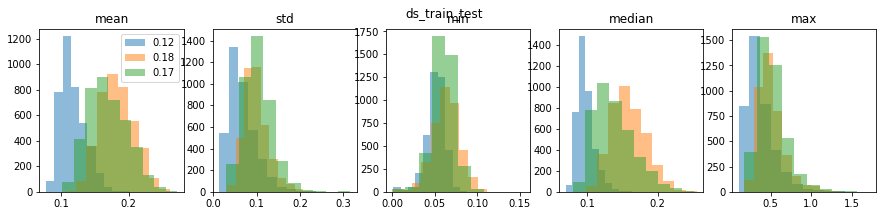

In [714]:

fig, axes = plt.subplots(1, 5, figsize=(5*3, 3))
for k, v in lt.items():
    fig.suptitle(k)
    
    l = [np.mean(x) for x in v]
    axes[0].hist(l, alpha=0.5, label='{:.2f}'.format(np.array(l).mean()))
    axes[0].set_title('mean')
    
    l = [np.std(x) for x in v]
    axes[1].hist(l, alpha=0.5)
    axes[1].set_title('std')
    
    l = [np.min(x) for x in v]
    axes[2].hist(l, alpha=0.5)
    axes[2].set_title('min')
    
    l = [np.median(x) for x in v]
    axes[3].hist(l, alpha=0.5)
    axes[3].set_title('median')
    
    l = [np.max(x) for x in v]
    axes[4].hist(l, alpha=0.5)
    axes[4].set_title('max')
    
axes[0].legend() 

In [579]:
def compute_margins(RESULTS, idx):
    DEVICE='cuda:0'
    model = RESULTS[idx].load_model(1, 'model').to(DEVICE)
    model.eval()

    DS_TRAIN_ORIGINAL = ds_factory_stratified_shuffle_split('cifar10_train', 250)[0]
    DS_TEST_ORIGINAL = ds_factory('cifar10_test')

    t = [transforms.ToTensor()]
    ds_stats = ds_statistics(DS_TRAIN_ORIGINAL)
    if True:
        t += [transforms.Normalize(
            ds_stats['channel_mean'],
            ds_stats['channel_std'])]
    to_tensor = transforms.Compose(t)
    ds_test  = Transformer(DS_TRAIN_ORIGINAL, transform=to_tensor)
    
    x, y = apply_model(model, ds_test)
    x = torch.tensor(x)
    y = torch.tensor(y)
    y_act_true = x.gather(1, y.unsqueeze(1))
    y_act_other_max = x.scatter(1,y.unsqueeze(1),-float('inf')).max(dim=1)[0]
    margins = y_act_true.squeeze() - y_act_other_max.squeeze()
    i_true = (margins > 0)
    return margins

In [724]:
m16 = compute_margins(RESULTS,20)
m22 = compute_margins(RESULTS,22)

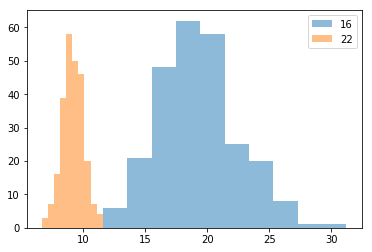

In [725]:
plt.figure()
plt.hist(m16.numpy(), alpha=0.5, bins=10, label='16');
plt.hist(m22.numpy(), alpha=0.5, bins=10, label='22');
plt.legend()
# plt.figure()
# plt.hist(m16[~(m17 > 0)].numpy(), alpha=0.5, bins=10);
# plt.hist(m22[~(m06 > 0)].numpy(), alpha=0.5, bins=10);
#plt.hist(margins[~i_true].numpy(), alpha=0.5)

In [594]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10,5)
        self.fc2 = nn.Linear(5,2)
    
    def forward(self,x):
        z = self.fc1(x)
        o = self.fc2(z)
        return z,o

In [610]:
inp = torch.rand(1,10)
net = Net()

In [613]:
z,o = net(inp)
torch.autograd.grad(o[0,1],z)[0]

tensor([[-0.0048, -0.4429,  0.2043, -0.0867,  0.3610]])